In [1]:
import dask.dataframe as dd
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
import torch
import gpytorch

In [3]:
import pyarrow as pa
import pyarrow.parquet as pq

In [4]:
from scipy.stats import pearsonr
from scipy.special import binom as binom
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

In [5]:
import Di

In [6]:
df = pd.read_csv("96ghpptzvf-4/SData2/CoCl2_geno.txt", sep='\t', nrows=5, engine='python')

In [7]:
ids = list(df.columns[3:])

In [8]:
geno_t = torch.load('matsui_geno_t.pt')

In [9]:
geno_t

tensor([[1., 2., 2.,  ..., 0., 0., 0.],
        [1., 2., 2.,  ..., 0., 0., 0.],
        [1., 2., 2.,  ..., 0., 0., 0.],
        ...,
        [1., 2., 2.,  ..., 1., 1., 1.],
        [1., 2., 2.,  ..., 1., 1., 1.],
        [1., 2., 2.,  ..., 1., 1., 1.]], device='cuda:0', dtype=torch.float64)

In [10]:
geno_t = torch.transpose(geno_t, 0, 1)
N, L = geno_t.shape

In [11]:
pheno = pd.read_csv("96ghpptzvf-4/SData6/CoCl2_pheno.txt", sep='\t', engine="python")

In [12]:
pheno.head()

,pheno,MATa,MATalpha,geno,qnorm,MATa_mid,MATalpha_mid,midparent
0,-0.021705,y39_A012,BYa_1C_A10,BYa_1C_A10.y39_A012,-0.021147,0.074002,-0.336769,-0.131384
1,-0.184045,y39_A02,BYa_1C_A10,BYa_1C_A10.y39_A02,-0.924553,-0.286352,-0.336769,-0.311561
2,-0.133887,y39_A03,BYa_1C_A10,BYa_1C_A10.y39_A03,-0.640047,-0.896266,-0.336769,-0.616517
3,-0.021991,y39_A04,BYa_1C_A10,BYa_1C_A10.y39_A04,-0.022688,0.593958,-0.336769,0.128595
4,0.088438,y39_A05,BYa_1C_A10,BYa_1C_A10.y39_A05,0.574957,0.576434,-0.336769,0.119833


In [13]:
pheno = pheno.set_index('geno')

In [14]:
pheno = pheno.loc[ids]

### test Diploid kernel

In [15]:
geno_ti = torch.tensor(geno_t, dtype=torch.int16)

/scratch/local/25669434/ipykernel_148888/3963038291.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  geno_ti = torch.tensor(geno_t, dtype=torch.int16)


In [21]:
sub = np.random.choice(range(N), 10000)

In [22]:
geno1 = geno_ti[sub, :1000]
geno2 = geno_ti[sub, :1000]

In [23]:
Di.L = L

In [24]:
geno1_h0 = 1.*(geno1 == 0.)
geno1_h1 = 1.*(geno1 == 2.)
geno2_h0 = 1.*(geno2 == 0.)
geno2_h1 = 1.*(geno2 == 2.)

In [25]:
S1 = torch.matmul(geno1%2, torch.transpose(geno2%2, 0, 1))

RuntimeError: "addmm_cuda" not implemented for 'Short'

In [26]:
S1 = torch.matmul(geno1%2, torch.transpose(geno2%2, 0, 1))
S2 = (torch.matmul(geno1_h0, torch.transpose(geno2_h0, 0, 1)) 
    + torch.matmul(geno1_h1, torch.transpose(geno2_h1, 0, 1)))


RuntimeError: "addmm_cuda" not implemented for 'Short'

In [27]:
S2 = (torch.matmul(geno1_h0, torch.transpose(geno2_h0, 0, 1)) 
    + torch.matmul(geno1_h1, torch.transpose(geno2_h1, 0, 1)))
D2 = (torch.matmul(geno1_h0, torch.transpose(geno2_h1, 0, 1)) 
    + torch.matmul(geno1_h1, torch.transpose(geno2_h0, 0, 1)))
D1 = L - S1 - S2 - D2


NameError: name 'S1' is not defined

In [39]:
Di.d(geno_t[sub, :10], geno_t[sub, :10])

RuntimeError: CUDA out of memory. Tried to allocate 18.63 GiB (GPU 0; 79.35 GiB total capacity; 59.02 GiB already allocated; 10.61 GiB free; 66.84 GiB reserved in total by PyTorch)

In [28]:
import Di
Di.set_params(geno_t[sub])

In [29]:
p = .8

In [30]:
from torch.utils.data import random_split
train, test = random_split(range(Di.N), lengths=[round(Di.N*p), Di.N-round(Di.N*p)])

In [31]:
y = np.array(pheno.pheno[sub])
y = torch.tensor(y)

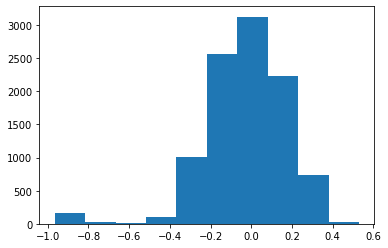

In [32]:
plt.hist(np.array(y))
plt.show()

In [33]:
idc = torch.arange(Di.N)

In [34]:
train_x = idc[train]
train_y = torch.tensor(y[train])
test_x = idc[test]
test_y = torch.tensor(y[test])

/scratch/local/25669434/ipykernel_148888/2969457204.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y = torch.tensor(y[train])
/scratch/local/25669434/ipykernel_148888/2969457204.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_y = torch.tensor(y[test])


In [35]:
train_x = train_x.cuda()
train_y = train_y.cuda().float()

In [ ]:
Di.make_elem_Ks(2)

In [129]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# initialize the new model
model = Di.DiGPModel_mix(train_x, train_y, likelihood)
# model = Di.RBFGPModel(train_x, train_y, likelihood)
# model = Di.RBFGPModel(train_x, train_y, likelihood)

In [130]:
model = model.cuda().double()
likelihood = likelihood.cuda()

In [131]:
model.covar_module.raw_lda = torch.nn.Parameter(torch.tensor(-8.))
model.covar_module.raw_eta = torch.nn.Parameter(torch.tensor(-12.))

model.covar_module.raw_ld1 = torch.nn.Parameter(torch.tensor(-8.))
model.covar_module.raw_et1 = torch.nn.Parameter(torch.tensor(-12.))

In [132]:
model.train()
output = model(train_x)

In [133]:
model.train()
likelihood.train()
losses = Di.train_model(model, likelihood, train_x, train_y, training_iter=300, lr=.2)

0


/home/juannanzhou/.local/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /pytorch/aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


20
40
60
80
100
120
140
160
180
200
220
240
260
280


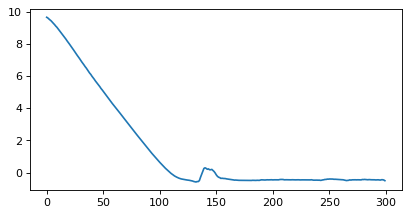

In [134]:
figure(figsize=(6, 3), dpi=80)
plt.plot(losses)
plt.show()

In [135]:
test_x = test_x.cuda()

In [136]:
model.eval()
f_preds = model(test_x)
y_preds = likelihood(model(test_x))

In [137]:
f_mean = f_preds.mean.cpu()

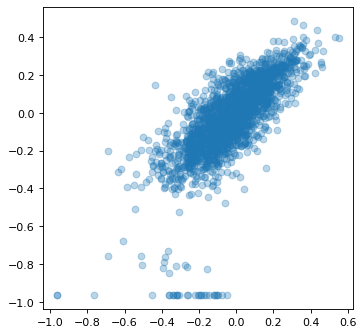

r2 = 0.534408
R2 = 0.519608
mse = 0.021183


In [138]:
figure(figsize=(5, 5), dpi=80)
plt.plot(f_mean.detach().numpy(), y[test], 'o', alpha=.3)
plt.show()
print('r2 = %f'%pearsonr(f_mean.detach().numpy(), y[test])[0]**2)
print('R2 = %f'%r2(y[test], f_mean.detach().numpy()))
print('mse = %f'%mse(f_mean.detach().numpy(), y[test]))

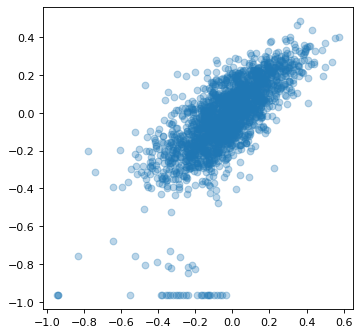

r2 = 0.498458
R2 = 0.463990
mse = 0.023635


In [104]:
figure(figsize=(5, 5), dpi=80)
plt.plot(f_mean.detach().numpy(), y[test], 'o', alpha=.3)
plt.show()
print('r2 = %f'%pearsonr(f_mean.detach().numpy(), y[test])[0]**2)
print('R2 = %f'%r2(y[test], f_mean.detach().numpy()))
print('mse = %f'%mse(f_mean.detach().numpy(), y[test]))

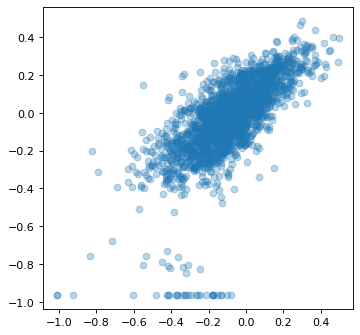

r2 = 0.497795
R2 = 0.374890
mse = 0.027564


In [94]:
figure(figsize=(5, 5), dpi=80)
plt.plot(f_mean.detach().numpy(), y[test], 'o', alpha=.3)
plt.show()
print('r2 = %f'%pearsonr(f_mean.detach().numpy(), y[test])[0]**2)
print('R2 = %f'%r2(y[test], f_mean.detach().numpy()))
print('mse = %f'%mse(f_mean.detach().numpy(), y[test]))

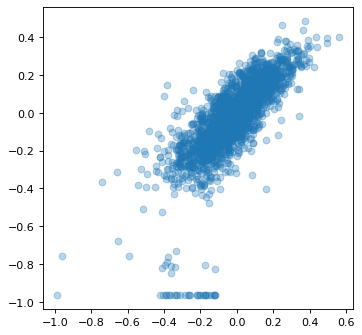

r2 = 0.570980
R2 = 0.567246
mse = 0.019082


In [125]:
figure(figsize=(5, 5), dpi=80)
plt.plot(f_mean.detach().numpy(), y[test], 'o', alpha=.3)
plt.show()
print('r2 = %f'%pearsonr(f_mean.detach().numpy(), y[test])[0]**2)
print('R2 = %f'%r2(y[test], f_mean.detach().numpy()))
print('mse = %f'%mse(f_mean.detach().numpy(), y[test]))

In [79]:
ker = Di.DiKernel().cuda()

In [80]:
ker(train_x, train_x).numpy()

array([[7.35748596e+016, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 5.66321656e-007, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 7.86404089e-043, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       ...,
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        6.19828784e-087, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 4.92368074e+117, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 1.71278929e+033]])